# Program - Print out and Plot profiles in SCM

**Content:**
- Plot profiles in SCM
- Print out profiles in SCM

**Author**: Yi-Hsuan Chen (yihsuan@umich.edu)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Open files

### Open SCM file

In [8]:
#--- open SCM file
#datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_scm/scm_taiesm1/scm_taiesm1.dycomsrf01.psflx.0415220929/run/"
datapath = "/lfs/home/yihsuanc/test/c1-scam-tendencies/xy01_scm_taiesm1.dycomsrf01.psflx.0419084112/run/"

#--- single file
filename_scm = "camrun.cam.h0.1999-07-11-00000.nc"
file_scm = datapath+"/"+filename_scm

ds_scm = xr.open_dataset(file_scm)
#ds_scm

### Open IOP file

In [9]:
datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_scm/iop/"
file_iop_rf01 = datapath+"/"+"DYCOMSrf01_4day_4scam.nc"

ds_rf01 = xr.open_dataset(file_iop_rf01)

#print(ds_rf01.q[0,:,0,0].values)
#print(ds_rf01.lev.values)


## Print out variable profiles

In [67]:
varnames_diag=["CLOUD",'CLDLIQ',"MACPDLIQ","MPDLIQ"]
ds_scm1 = yhc.diagnose_var(ds_scm, varnames_diag)

ds_name="ds_scm"
varnames = ['TBP','T','TAP',"TTEND_TOT"]
dim_name = "[tt,:,0,0]"
text_all = ', '.join([f"{ds_name}.{var}{dim_name}" for var in varnames])
print(text_all)

#--- given varnames_diag, I want to print them out
tt=0
#yhc.print_1d_arrays(ds_scm.TBP[tt,:,0,0], ds_scm.T[tt,:,0,0], ds_scm.TAP[tt,:,0,0], ds_scm.TTEND_TOT[tt,:,0,0])
yhc.print_1d_arrays(ds_scm.TBP[tt,:,0,0], ds_scm.TAP[tt,:,0,0], ds_scm.TTEND_TOT[tt,:,0,0], ds_scm.DTCORE[tt,:,0,0])


ds_scm.TBP[tt,:,0,0], ds_scm.T[tt,:,0,0], ds_scm.TAP[tt,:,0,0], ds_scm.TTEND_TOT[tt,:,0,0]
Index	lev	TBP	TAP	TTEND_TOT	DTCORE
1	3.64346569404006	234.0	234.07664489746094	6.386498716892675e-05	0.0
2	7.594819646328688	234.0	234.04808044433594	4.0072576666716486e-05	0.0
3	14.356632251292467	233.2023162841797	233.22447204589844	1.8452210497343913e-05	0.0
4	24.612220004200935	226.12950134277344	226.14791870117188	1.534502735012211e-05	0.0
5	38.26829977333546	222.0059814453125	222.01527404785156	7.748068128421437e-06	0.0
6	54.59547974169254	218.92538452148438	218.92935180664062	3.3122969398391433e-06	0.0
7	72.01245054602623	209.34767150878906	209.35842895507812	8.969657756097149e-06	0.0
8	87.82123029232025	209.20156860351562	209.2079315185547	5.301266355672851e-06	0.0
9	103.31712663173676	209.05836486816406	209.064208984375	4.881546374235768e-06	0.0
10	121.54724076390266	208.88987731933594	208.89706420898438	5.991265879856655e-06	0.0
11	142.99403876066208	212.67398071289062	212.6789703369140

## Plot functions

### function - plot_scm_profiles

In [68]:
import matplotlib.pyplot as plt

#####################
#####################
#####################
def set_profile_varnames (opt):
    """
    ----------------------
    Description:
       Return a dictionary variable that will be used in the function, 

    Input arguments:
       opt (str): option. Currently supported: [DT_budget, DQV_budget, DQL_budget, DQI_budget]

    Return:
       varnames (dict)

    Example:
      import yhc_module as yhc
      varnames = set_profile_varnames('DT_budget')

    Date created: 2024-03-20
    ----------------------
    """

    func_name = "set_profile_varnames"

    #--- colors for each process
    color_tot = 'black' ; color_dyn = 'darkgray' ; color_PT = 'red' ; color_sum = color_PT
    color_ZM = 'blue'   ; color_CMF = 'cyan'     ; color_DPDLF = 'royalblue' ; color_SHDLF = 'skyblue'
    color_MACP = 'green' ; color_MP = 'limegreen' ; color_QRL = 'orange' ; color_QRS = 'pink' ; 
    color_vdiff = 'purple' ; color_gwd = 'yellow'
    color_MACP = 'cyan'
    
    #@@@@@@@@@@@@@@@@@
    if (opt == "DT_budget"):
        varnames = {
            'TTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [TTEND_TOT]'},
            'DTCORE': {'color':color_dyn, 'label': 'Dynamics [DTCORE]'},
            'PTTEND': {'color':color_PT, 'label': 'All phys [PTTEND]'},
            'DT_deep': {'color': color_ZM, 'label':'Deep convection [ZMDT+ZMMTT+EVAPTZM]'},
            'CMFDT': {'color': color_CMF, 'label': 'Shallow convection [CMFDT]'},
            'DPDLFT': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFT]'},
            'SHDLFT': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFT]'},
            'MACPDT': {'color':color_MACP, 'label':'Macrophysics [MACPDT]'},
            'MPDT': {'color':color_MP, 'label':'Microphysics [MPCT]'},
            'QRL': {'color':color_QRL, 'label': 'LW radiation [QRL]'},
            'QRS': {'color':color_QRS, 'label':'SW radiation [QRS]'},
            'DTV': {'color':color_vdiff, 'label': 'PBL & turbulence [DTV]'},
            'TTGWORO': {'color':color_gwd, 'label':'grav wave drag [TTGWORO]'},
            'DT_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }
        
    #@@@@@@@@@@@@@@@@@
    elif (opt == "DT_budget01"):
       varnames = {
            'TTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [TTEND_TOT]'},
            'DTCORE': {'color':color_dyn, 'label': 'Dynamics [DTCORE]'},
            'PTTEND': {'color':color_PT, 'label': 'All phys [PTTEND]'},
            #'DT_deep': {'color': color_ZM, 'label':'Deep convection [ZMDT+ZMMTT+EVAPTZM]'},
            #'CMFDT': {'color': color_CMF, 'label': 'Shallow convection [CMFDT]'},
            #'DPDLFT': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFT]'},
            #'SHDLFT': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFT]'},
            'MACPDT': {'color':color_MACP, 'label':'Macrophysics [MACPDT]'},
            'MPDT': {'color':color_MP, 'label':'Microphysics [MPCT]'},
            'QRL': {'color':color_QRL, 'label': 'LW radiation [QRL]'},
            #'QRS': {'color':color_QRS, 'label':'SW radiation [QRS]'},
            'DTV': {'color':color_vdiff, 'label': 'PBL & turbulence [DTV]'},
            #'TTGWORO': {'color':color_gwd, 'label':'grav wave drag [TTGWORO]'},
            #'DT_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }
    
    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQV_budget"):        
        varnames = {
            'QVTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QVTEND_TOT]'},
            'DQVCORE': {'color':color_dyn, 'label': 'Dynamics [DQVCORE]'},
            'PTEQ': {'color':color_PT, 'label': 'All phys [PTEQ]'},
            'DQV_deep': {'color': color_ZM, 'label':'Deep convection [ZMDQ+EVAPQZM]'},
            'CMFDQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDQ]'},
            'MACPDQ': {'color':color_MACP, 'label':'Macrophysics [MACPDQ]'},
            'MPDQ': {'color':color_MP, 'label':'Microphysics [MPDQ]'},
            'VD01': {'color':color_vdiff, 'label': 'PBL & turbulence [VD01]'},
            'DQV_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQV_budget01"):        
        varnames = {
            'QVTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QVTEND_TOT]'},
            'PTEQ': {'color':color_PT, 'label': 'All phys [PTEQ]'},
            'DQVCORE': {'color':color_dyn, 'label': 'Dynamics [DQVCORE]'},
            #'DQV_deep': {'color': color_ZM, 'label':'Deep convection [ZMDQ+EVAPQZM]'},
            #'CMFDQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDQ]'},
            'MACPDQ': {'color':color_MACP, 'label':'Macrophysics [MACPDQ]'},
            'MPDQ': {'color':color_MP, 'label':'Microphysics [MPDQ]'},
            'VD01': {'color':color_vdiff, 'label': 'PBL & turbulence [VD01]'},
            #'DQV_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }
    
    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQL_budget"):           
        varnames = {
            'QLTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QLTEND_TOT]'},
            'DQLCORE': {'color':color_dyn, 'label': 'Dynamics [DQLCORE]'},
            'PTECLDLIQ': {'color':color_PT, 'label': 'All phys [PTECLDLIQ]'},
            'ZMDLIQ': {'color': color_ZM, 'label':'Deep convection [ZMDLIQ]'},
            'CMFDLIQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDLIQ]'},
            'DPDLFLIQ': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFLIQ]'},
            'SHDLFLIQ': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFLIQ]'},
            'MACPDLIQ': {'color':color_MACP, 'label':'Macrophysics [MACPDLIQ]'},
            'MPDLIQ': {'color':color_MP, 'label':'Microphysics [MPDLIQ]'},
            'VDCLDLIQ': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDLIQ]'},
            #'DQL_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQL_budget01"):           
        varnames = {
            'QLTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QLTEND_TOT]'},
            'DQLCORE': {'color':color_dyn, 'label': 'Dynamics [DQLCORE]'},
            'PTECLDLIQ': {'color':color_PT, 'label': 'All phys [PTECLDLIQ]'},
            #'ZMDLIQ': {'color': color_ZM, 'label':'Deep convection [ZMDLIQ]'},
            #'CMFDLIQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDLIQ]'},
            #'DPDLFLIQ': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFLIQ]'},
            #'SHDLFLIQ': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFLIQ]'},
            'MACPDLIQ': {'color':color_MACP, 'label':'Macrophysics [MACPDLIQ]'},
            'MPDLIQ': {'color':color_MP, 'label':'Microphysics [MPDLIQ]'},
            'VDCLDLIQ': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDLIQ]'},
            #'DQL_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }
    
    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQI_budget"):   
        varnames = {
            'QITEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QITEND_TOT]'},
            'DQICORE': {'color':color_dyn, 'label': 'Dynamics [DQICORE]'},
            'PTECLDICE': {'color':color_PT, 'label': 'All phys [PTECLDICE]'},
            'ZMDICE': {'color': color_ZM, 'label':'Deep convection [ZMDICE]'},
            'CMFDICE': {'color': color_CMF, 'label': 'Shallow convection [CMFDICE]'},
            'DPDLFICE': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFICE]'},
            'SHDLFICE': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFICE]'},
            'MACPDICE': {'color':color_MACP, 'label':'Macrophysics [MACPDICE]'},
            'MPDICE': {'color':color_MP, 'label':'Microphysics [MPDICE]'},
            'VDCLDICE': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDICE]'},
            #'DQI_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    else:
        error_msg = f"ERROR: function [{func_name}] does not support [{opt}]."
        raise ValueError(error_msg)


    return varnames

#####################
#####################
#####################
def plot_scm_profiles(ds, varnames,
                      tt=5, jj=0, ii=0, 
                      title = "TaiESM1 SCM DYCOMS_RF01", xlabel = "VAR", yvar = 'lev', ylabel = "Nominal Pressure (hPa)",
                      ylim=[1000,850], xlim=None, 
                      do_units=True):
    """
    Plot variables from an xarray dataset with yvar on the Y axis.

    Parameters:
    - ds (xarray.Dataset): The dataset containing the variables.
    - varnames (dict, optional): A dictionary mapping variable names to styles, including colors, linestyles, and labels.
    - tt, jj, ii: indexes for time, lat, lon, respectively
    
    Returns:
    - None
    """

    # Plot each variable
    for var_name, style in varnames.items():

        #--- get variable
        ds = yhc.diagnose_var(ds, [var_name])  # pass var_name as a list, otherwise it will read the first character
        var_data = ds[var_name].isel(time=tt, lat=jj, lon=ii)
        if (do_units): var_data = yhc.unit_convert(var_data)
        units = var_data.attrs['units']
        
        #--- lev
        lev = ds[yvar]

        # If 'label' is not provided in styles, set label as var_name
        label = style.get('label', var_name)
        marker_default = 'o'
        linestyle_default = '-'
        
        # Plot the variable with style
        plt.plot(var_data, lev, label=label, color=style.get('color', 'blue'), linestyle=style.get('linestyle', linestyle_default), marker=marker_default, markersize=4)

    # Add labels and legend

    #--- title and x & y labels
    plt.xlabel(f"{xlabel} ({units})")
    plt.ylabel(ylabel)
      #lat_formatted = "{:.2f}".format(ds['lat'][jj].values)
      #lon_formatted = "{:.2f}".format(ds['lon'][ii].values)
      #plt.title(f"{title}, time step = {tt}, lat={lat_formatted}, lon={lon_formatted}")
    plt.title(f"{title}, time step = {tt}", y=1.1)
    plt.title(f"{xlabel}", loc='left', y=1.001, fontsize = 10)
    plt.title(f"{units}", loc='right', y=1.001, fontsize = 10)

    #--- legend
    #plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.legend()

    #--- grids and axises
    plt.grid(True, color='gray', linestyle='--')
    plt.gca().invert_yaxis()
    plt.minorticks_on()

    plt.ylim(ylim)
    plt.xlim(xlim)
    
    plt.show()
    #return plt

# Example usage:
# Assuming 'ds' is your xarray dataset and 'varnames' is a dictionary mapping variable names to styles
varnames = {
    'MPDT': {'color': 'red', 'linestyle': '--', 'label': 'Custom Label 1'},
    'CMFDT': {'color': 'green', 'linestyle': '-.'},
    'DTCORE': {'color': 'blue'},
    'DT_deep': {'color': 'pink'},
}

#plot_scm_profiles (ds_scm, varnames, xlabel="Temperature tendency")


### plot_scm_profiles_1vNt

In [70]:
def plot_scm_profiles_1vNt (ds, variable_names, 
                            tt1=0, tt2=6, jj=0, ii=0, ylim_p=[1000,850], xlim=None,
                            title = "TaiESM1 SCM RF01 :", 
                            do_units=True):
    """
    ----------------------
    Description:
      Given a SCM dataset and variable names, plot the time steps for each variable

    Input arguments:
      ds: a Xarray Dataset
      variable_names: a list containing the variables in the ds
      tt1, tt2: plot the time indexes from tt1 to tt2
      jj, ii: indexes for lat and lon, respectively
      ylim_p: upper and lower limit of y axis
      xlim  : upper and lower limit of each variable
      title : title on each plot
      do_units: do unit conversion using yhc.unit_convert
    
    Return:
      a plot

    Example:
      import yhc_module as yhc
      
      ttend_min=-100 ; ttend_max=300

      xlim_custom = {
            "T": [283, 295],
            "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], 
                    }
      plot_scm_profiles_1vNt(ds_scm, ['T','TTEND_TOT','MACPDT','MPDT'], xlim=xlim_custom)

    Date created: 2024-04-18
    ----------------------
    """
    fig, axes = plt.subplots(1, len(variable_names), figsize=(4*len(variable_names), 4))

    for i, var_name in enumerate(variable_names):
        ds1 = yhc.diagnose_var(ds, [var_name])  # pass var_name as a list, otherwise it will read the first character
        var_data = ds1[var_name][tt1:tt2, :, jj, ii]
        if (do_units): var_data = yhc.unit_convert(var_data)
        units = var_data.attrs['units']
        
        ax = axes[i]

        if xlim is not None and var_name in xlim and xlim[var_name] is not None:
            xlim_var = xlim[var_name]
        else:    
            xlim_var = None
        
        var_data.plot.line(ax=ax, y='lev', yincrease=False, ylim=ylim_p, xlim=xlim_var, marker='o', markersize=4)
        
        ax.grid(True)
        ax.minorticks_on() 
        ax.grid(which='major', color='gray', linestyle='-.', linewidth=0.5)        # set both X and Y grids
        ax.set_title(f"{title} {var_name}")
        ax.set_ylabel("Nominal Pressure (hPa)")
    
    plt.tight_layout()
    plt.show()

#========

ttend_min=-100 ; ttend_max=300
tmin=282 ; tmax=295

xlim_custom = {
    "T": [tmin,tmax], "TBP": [tmin,tmax],  "TAP": [tmin,tmax], 
    "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], "DTCORE": [ttend_min, ttend_max],
    
}
#plot_scm_profiles_1vNt(ds_scm, ['TBP','TAP', 'TTEND_TOT', 'DTCORE'], tt2=5, xlim=xlim_custom)
#plot_scm_profiles_1vNt(ds_scm, ['T','TTEND_TOT','MACPDT','MPDT'], xlim=xlim_custom)
#plot_scm_variables(ds_scm, ['Q','QVTEND_TOT'], xlim=xlim_custom)
#plot_scm_variables(ds_scm, ['CLDLIQ','QLTEND_TOT'], xlim=xlim_custom)


## Plot

### 1vNt: T, TBP, TAP, TTEND_TOT

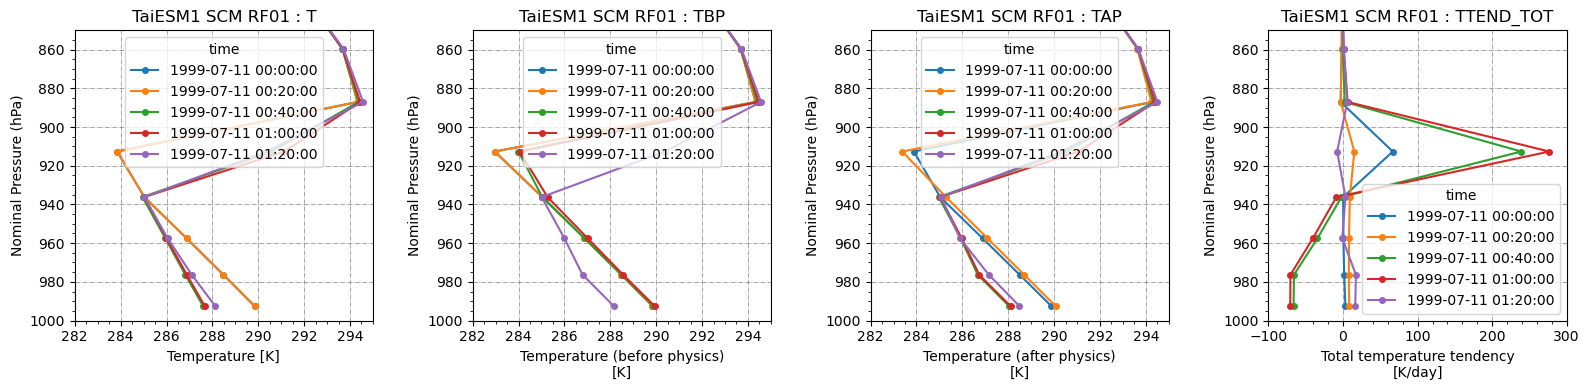

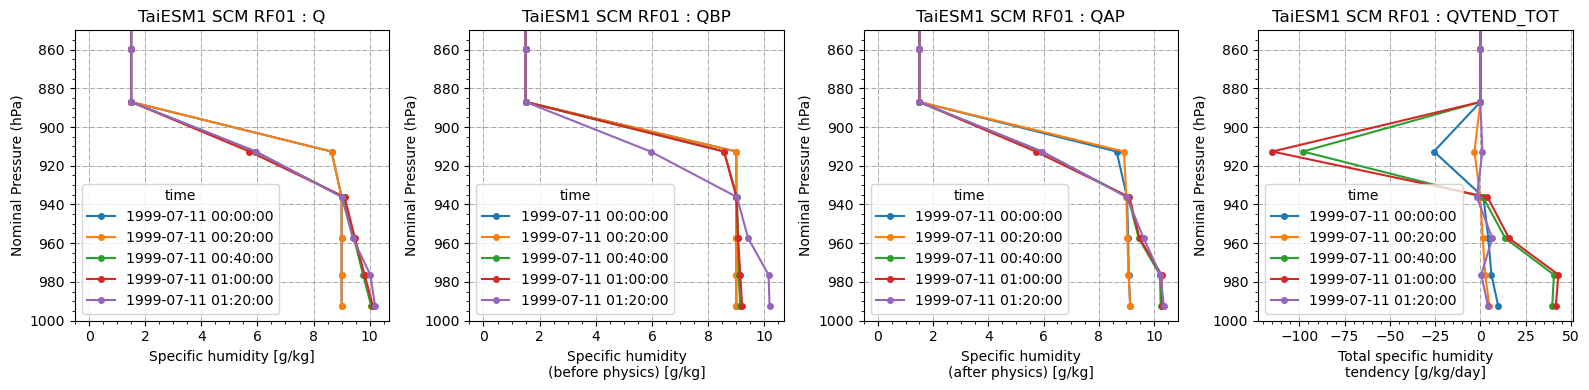

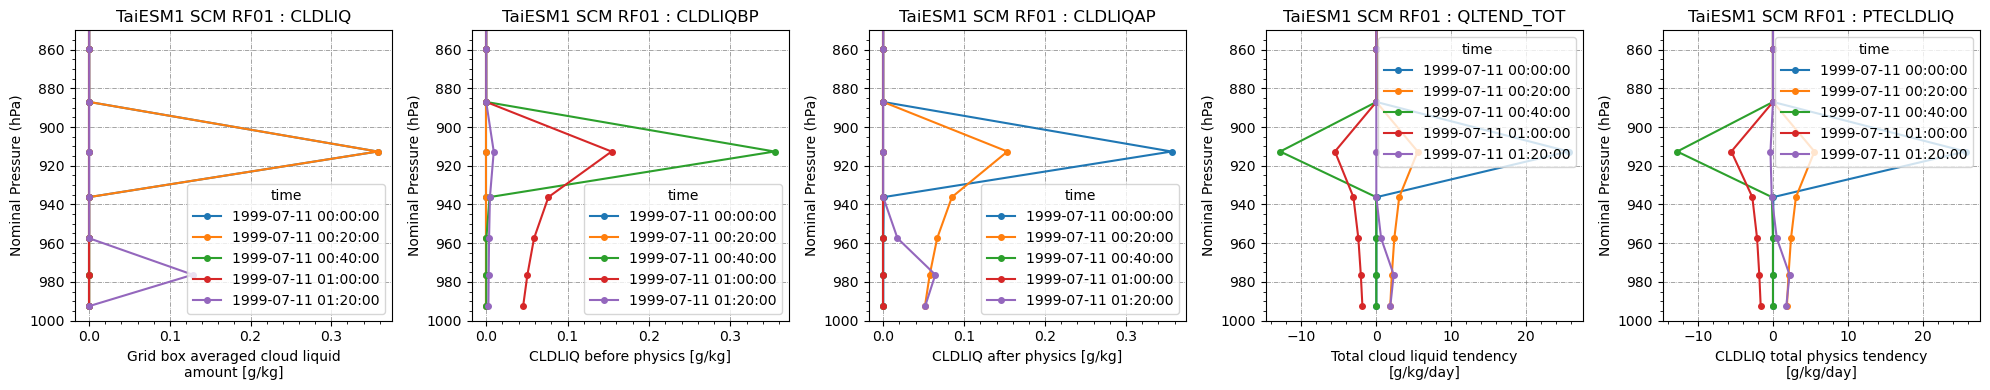

In [86]:
ttend_min=-100 ; ttend_max=300
tmin=282 ; tmax=295

xlim_custom = {
    "T": [tmin,tmax], "TBP": [tmin,tmax],  "TAP": [tmin,tmax], 
    "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], "DTCORE": [ttend_min, ttend_max],
    
}
plot_scm_profiles_1vNt(ds_scm, ['T', 'TBP','TAP', 'TTEND_TOT', ], tt2=5, xlim=xlim_custom)
plot_scm_profiles_1vNt(ds_scm, ['Q', 'QBP','QAP', 'QVTEND_TOT', ], tt2=5, xlim=xlim_custom)
plot_scm_profiles_1vNt(ds_scm, ['CLDLIQ', 'CLDLIQBP','CLDLIQAP', 'QLTEND_TOT', 'PTECLDLIQ'], tt2=5, xlim=xlim_custom)


### nV1t: T, TBP, and TAP

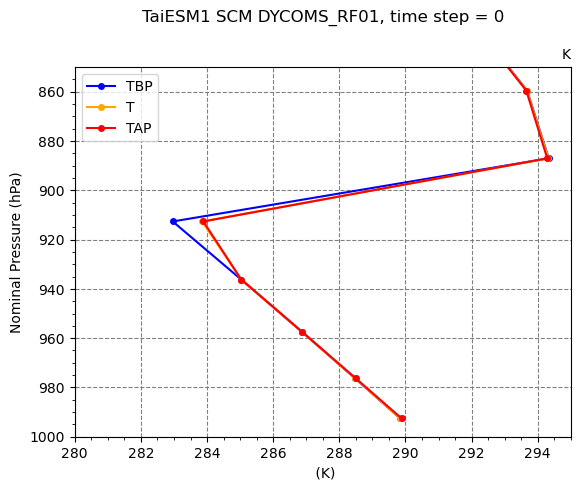

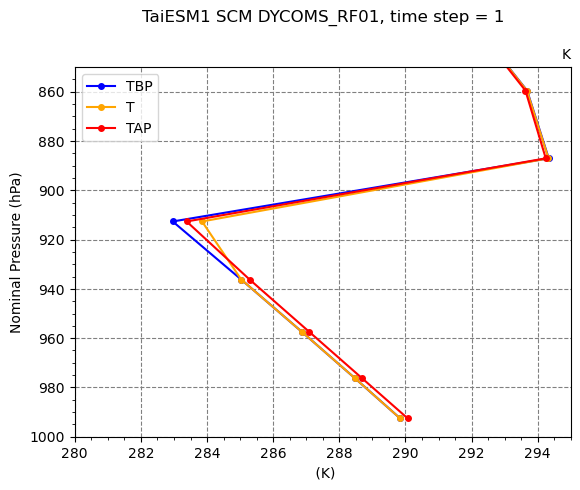

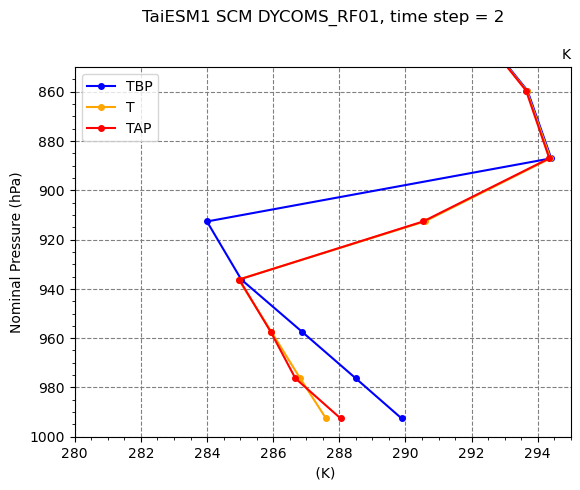

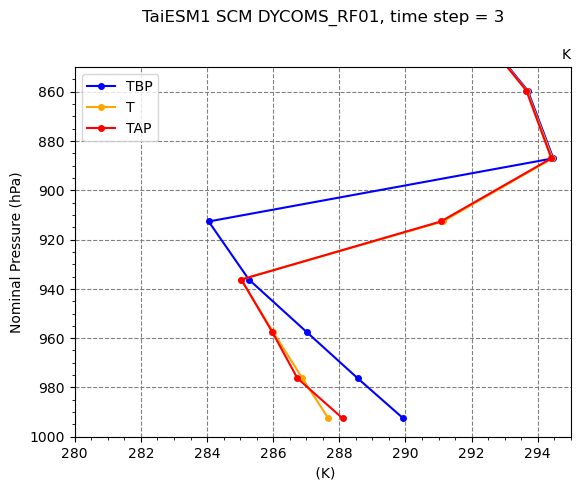

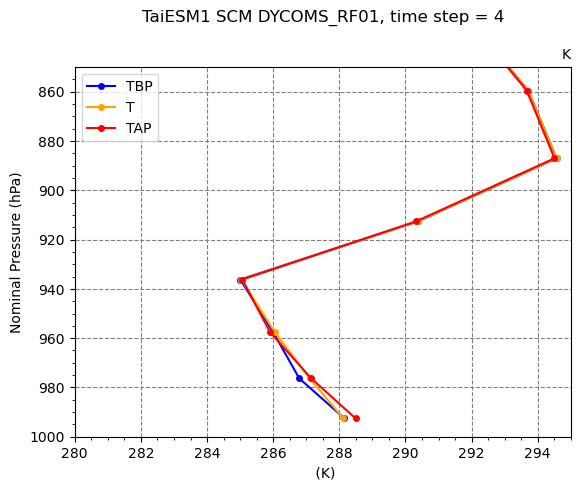

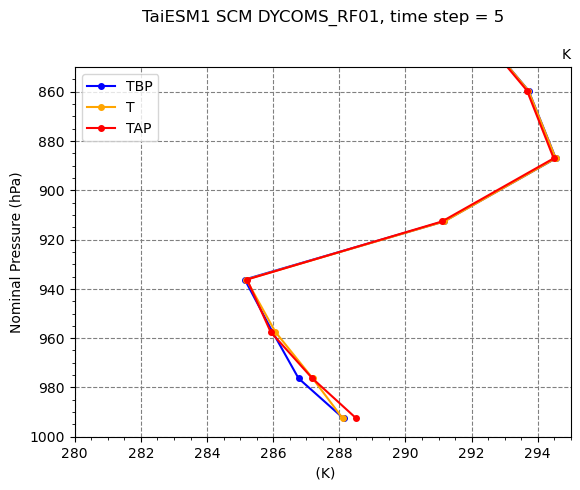

In [38]:
varnames = {
    'TBP': {'color': 'blue', 'linestyle': '-'},
    'T': {'color': 'orange', 'linestyle': '-'},
    'TAP': {'color': 'red', 'linestyle': '-'},

           }
tt=0
plot_scm_profiles (ds_scm, varnames, tt=0, xlabel="")
plot_scm_profiles (ds_scm, varnames, tt=1, xlabel="")
plot_scm_profiles (ds_scm, varnames, tt=2, xlabel="")
plot_scm_profiles (ds_scm, varnames, tt=3, xlabel="")
plot_scm_profiles (ds_scm, varnames, tt=4, xlabel="")
plot_scm_profiles (ds_scm, varnames, tt=5, xlabel="")

### T tendency

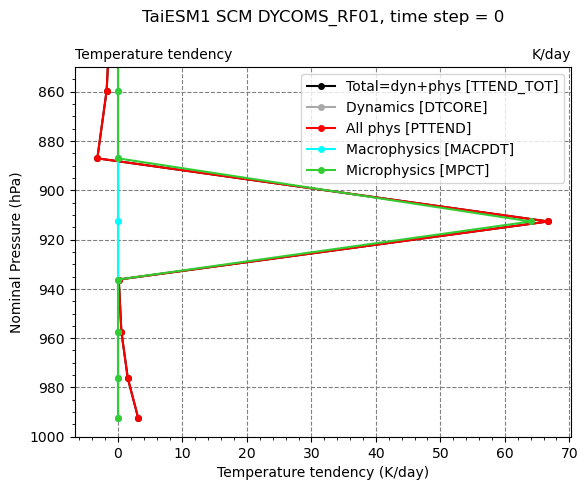

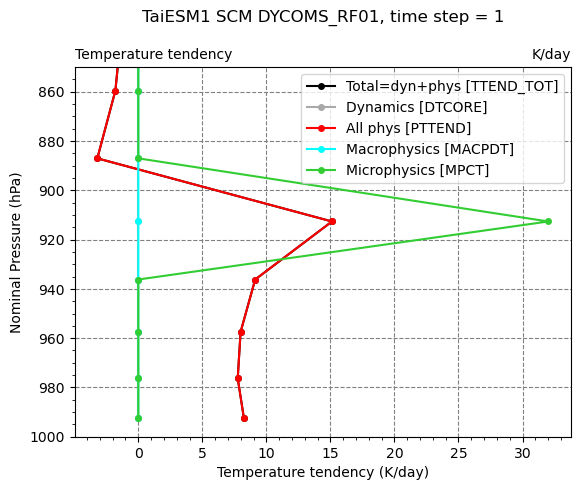

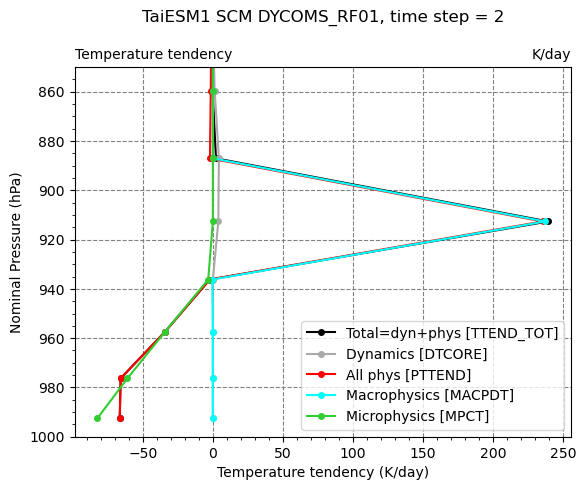

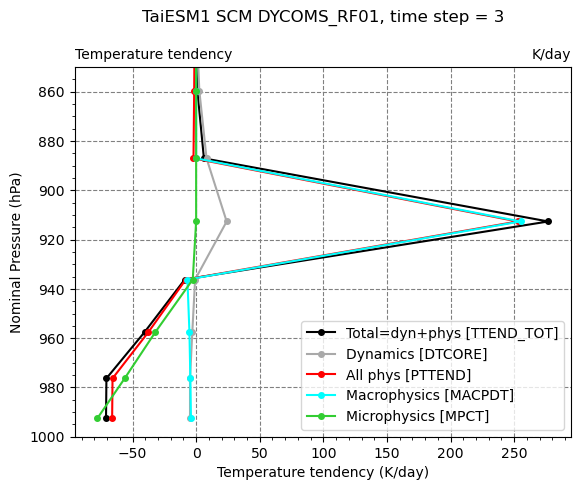

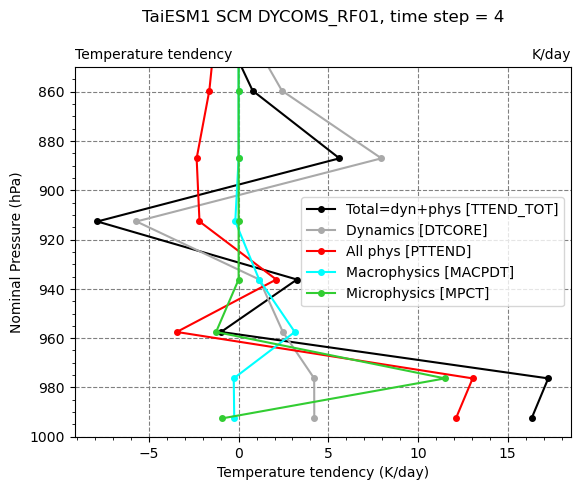

In [73]:
#varnames = set_profile_varnames('DT_budget01')

#--- colors for each process
color_tot = 'black' ; color_dyn = 'darkgray' ; color_PT = 'red' ; color_sum = color_PT
color_ZM = 'blue'   ; color_CMF = 'cyan'     ; color_DPDLF = 'royalblue' ; color_SHDLF = 'skyblue'
color_MACP = 'green' ; color_MP = 'limegreen' ; color_QRL = 'orange' ; color_QRS = 'pink' ; 
color_vdiff = 'purple' ; color_gwd = 'yellow'
color_MACP = 'cyan'

varnames = {
            'TTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [TTEND_TOT]'},
            'DTCORE': {'color':color_dyn, 'label': 'Dynamics [DTCORE]'},
            'PTTEND': {'color':color_PT, 'label': 'All phys [PTTEND]'},
            #'DT_deep': {'color': color_ZM, 'label':'Deep convection [ZMDT+ZMMTT+EVAPTZM]'},
            #'CMFDT': {'color': color_CMF, 'label': 'Shallow convection [CMFDT]'},
            #'DPDLFT': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFT]'},
            #'SHDLFT': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFT]'},
            'MACPDT': {'color':color_MACP, 'label':'Macrophysics [MACPDT]'},
            'MPDT': {'color':color_MP, 'label':'Microphysics [MPCT]'},
            #'QRL': {'color':color_QRL, 'label': 'LW radiation [QRL]'},
            #'QRS': {'color':color_QRS, 'label':'SW radiation [QRS]'},
            #'DTV': {'color':color_vdiff, 'label': 'PBL & turbulence [DTV]'},
            #'TTGWORO': {'color':color_gwd, 'label':'grav wave drag [TTGWORO]'},
            #'DT_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

plot_scm_profiles (ds_scm, varnames, tt=0, xlabel="Temperature tendency")
plot_scm_profiles (ds_scm, varnames, tt=1, xlabel="Temperature tendency")
plot_scm_profiles (ds_scm, varnames, tt=2, xlabel="Temperature tendency")
plot_scm_profiles (ds_scm, varnames, tt=3, xlabel="Temperature tendency")
plot_scm_profiles (ds_scm, varnames, tt=4, xlabel="Temperature tendency")

### QV tendency

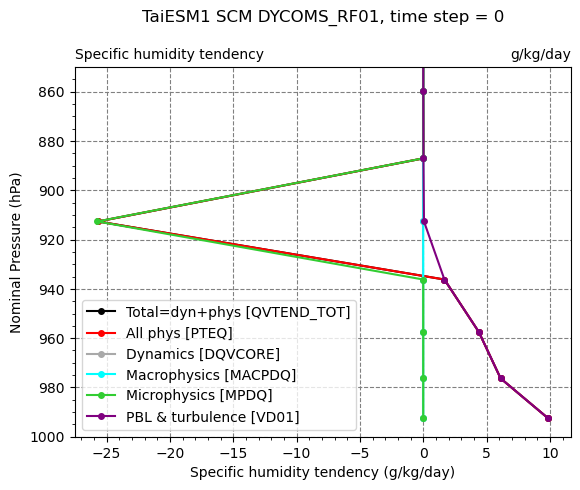

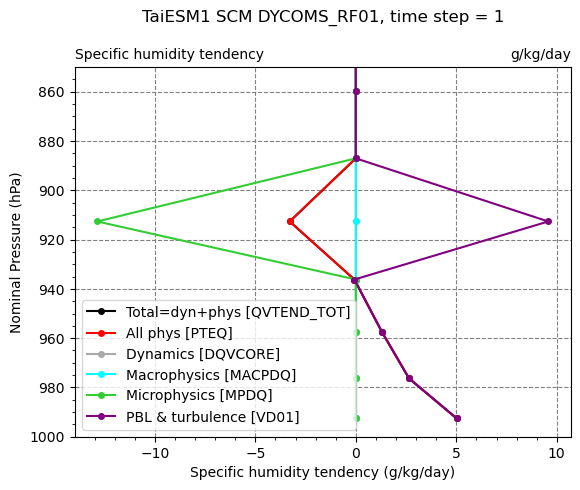

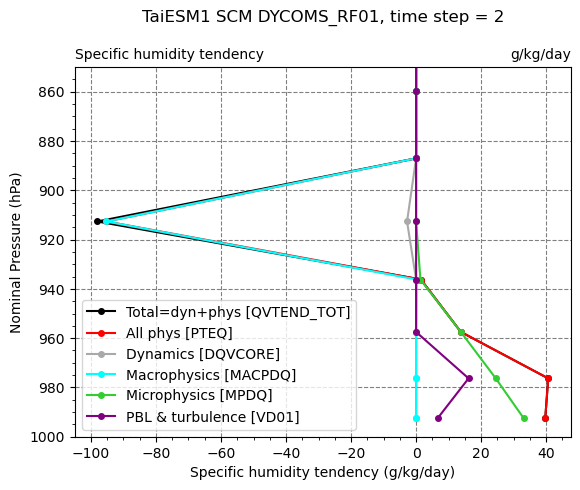

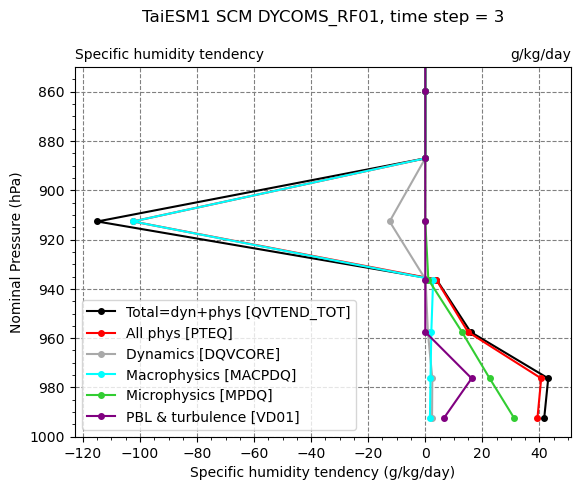

In [74]:
varnames = set_profile_varnames('DQV_budget01')

plot_scm_profiles (ds_scm, varnames, tt=0, xlabel="Specific humidity tendency")
plot_scm_profiles (ds_scm, varnames, tt=1, xlabel="Specific humidity tendency")
plot_scm_profiles (ds_scm, varnames, tt=2, xlabel="Specific humidity tendency")
plot_scm_profiles (ds_scm, varnames, tt=3, xlabel="Specific humidity tendency")

### QL tendency

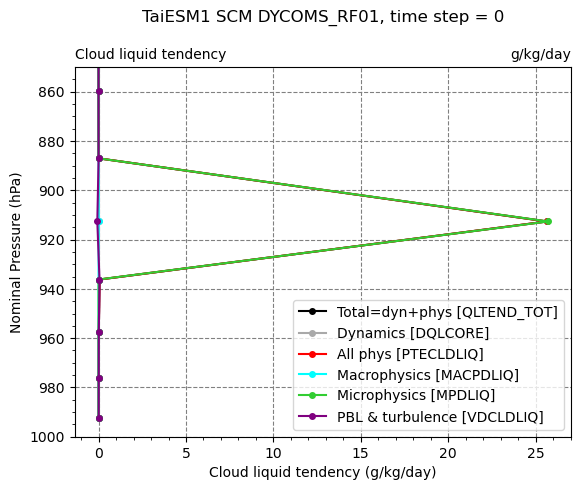

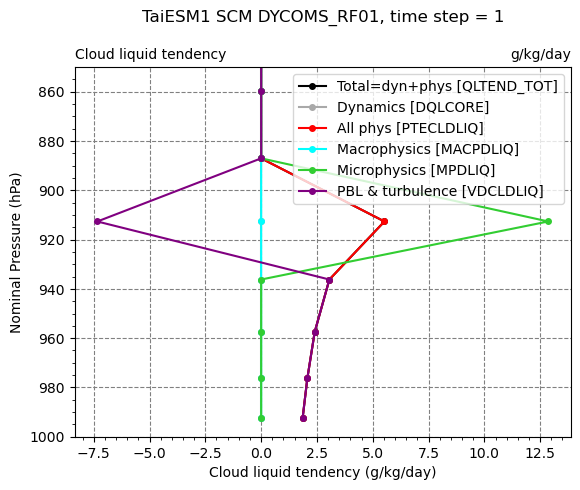

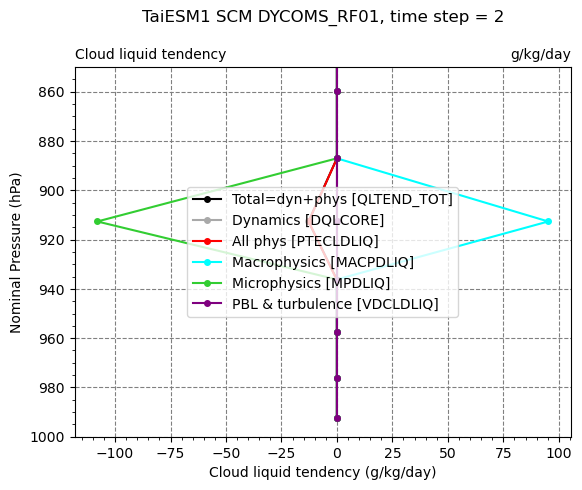

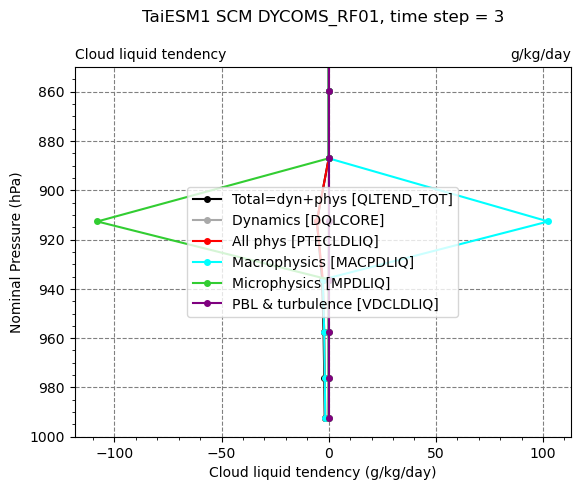

In [75]:
varnames = set_profile_varnames('DQL_budget01')

plot_scm_profiles (ds_scm, varnames, tt=0, xlabel="Cloud liquid tendency")
plot_scm_profiles (ds_scm, varnames, tt=1, xlabel="Cloud liquid tendency")
plot_scm_profiles (ds_scm, varnames, tt=2, xlabel="Cloud liquid tendency")
plot_scm_profiles (ds_scm, varnames, tt=3, xlabel="Cloud liquid tendency")

### QI tendency

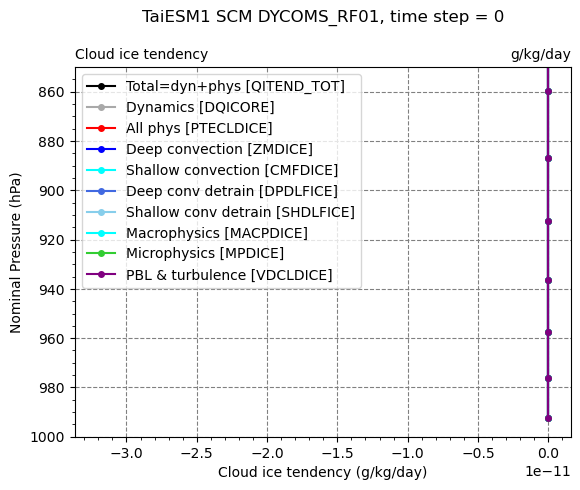

In [76]:
varnames = set_profile_varnames('DQI_budget')

tt=0
plot_scm_profiles (ds_scm, varnames, tt=tt, xlabel="Cloud ice tendency")